# Loading and Wrangling Data

Loading in data using the functions that we made:

In [43]:
oneBatch = True

In [44]:
# Run if you want one batch
import data_loading as dt
import os


if oneBatch:
    batchNum = 1
    if os.path.exists(f'batch{batchNum}/part_{batchNum}/'):
        ids, images = dt.importImages(f'batch{batchNum}/part_{batchNum}/')
    else:
        ids, images = dt.loadImageBatch(batchNum)
else:
    batchNums = list(range(1,13))
    ids, images = dt.loadImageBatches(batchNums)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1p-7tN3D3g80GQoIR8tYIgzQUMTqNWwGZ
From (redirected): https://drive.google.com/uc?id=1p-7tN3D3g80GQoIR8tYIgzQUMTqNWwGZ&confirm=t&uuid=cdb3b968-73cc-4c41-a01f-2cbbc36a2f9b
To: /Users/sergiomartelo/Documents/college/ML/project/BJJ_machine_learning/batch1.zip


















































































































































































































































































































































































































































































































































































































100%|██████████| 1.24G/1.24G [01:11<00:00, 17.3MB/s]
  6%|▌         | 76.5M/1.24G [21:2

Getting annotations and getting them into the correct order:

In [45]:
import pandas as pd
annotations = pd.read_csv("data/annotations.csv")
annotations.head()

,position,image
0,standing,1
1,standing,2
2,standing,3
3,standing,4
4,standing,5


In [46]:
position_maps= {"standing": 0, 
                "takedown1": 1,
                "takedown2": 2,
                "open_guard1": 3,
                "open_guard2": 4,
                "half_guard1": 5,
                "half_guard2": 6,
                "closed_guard1": 7,
                "closed_guard2": 8,
                "5050_guard": 9,
                "mount1": 10,
                "mount2": 11,
                "back1": 12,
                "back2": 13,
                "turtle1": 14,
                "turtle2": 15,               
                "side_control1" : 16,
                "side_control2" : 17}


labels = []
for id in ids:
    labels.append(position_maps[annotations[annotations['image'] == id]['position'].reset_index(drop=True)[0]])

In [47]:
labels[0:20]

[3, 8, 7, 3, 4, 3, 4, 3, 3, 3, 8, 7, 3, 8, 7, 3, 3, 4, 4, 3]

Converting images to tensors:

In [48]:
import torch
import numpy as np

# Converting into torch tensors
for i, img in enumerate(images):
    images[i] = torch.from_numpy(np.array(img))

# Convolutional Neural Net

## Creating Neural Net

In [55]:
# Data argumentation
from torchvision import transforms
data_transforms = transforms.Compose([
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180))
])

# CNN
from torch import nn
import torchvision
class my_net(nn.Module):
    
    ## Constructor commands
    def __init__(self):
        super(my_net, self).__init__()
        
        ## Define architecture
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3,8,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,16,2,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(3600, 200),
            nn.ReLU(),
            nn.Linear(200, 18)
        )
    
    ## Function to generate predictions
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores


## Training Neural Net

Train-test split:

In [56]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    images, labels, test_size=0.25, random_state=42)

train_X = torch.from_numpy(train_X)
train_X = torch.movedim(train_X, source=3, destination=1)

test_X = torch.from_numpy(test_X)
test_X = torch.movedim(test_X, source=3, destination=1)

In [57]:
## Hyperparms
epochs = 300
lrate = 0.001
bsize = 28

## For reproduction purposes 
torch.manual_seed(3)

## Cost Function
cost_fn = nn.CrossEntropyLoss()

## Intialize the model
net = my_net()

## Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

## Make DataLoader
from torch.utils.data import DataLoader, TensorDataset
y_tensor = torch.Tensor(train_y)
train_loader = DataLoader(TensorDataset(train_X.type(torch.FloatTensor), 
                        y_tensor.type(torch.LongTensor)), batch_size=bsize)

## Re-run the training loop, notice the new data_transforms() command
track_cost = np.zeros(epochs)
cur_cost = 0.0

for epoch in range(epochs):
    cur_cost = 0.0
    correct = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        ## Transform the input data using our data augmentation strategies
        inputs = data_transforms(inputs)
        
        ## Same as before
        optimizer.zero_grad()
        outputs = net(inputs)
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
        cost.backward()
        optimizer.step()
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
#     print(f"Epoch: {epoch} Cost: {cur_cost}") ## Uncomment this if you want printed updates
    
    

Calculating training accuracy:

In [58]:
## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in train_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Training Accuracy is {correct/total}")

Training Accuracy is 0.6256256256256256


Calculating testing accuracy:

In [59]:

## Combine X and y tensors into a TensorDataset and DataLoader
test_loader = DataLoader(TensorDataset(test_X.type(torch.FloatTensor), 
                        torch.Tensor(test_y).type(torch.LongTensor)), batch_size=bsize)

## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in test_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Test Accuracy is {correct/total}")

Test Accuracy is 0.5949720670391061


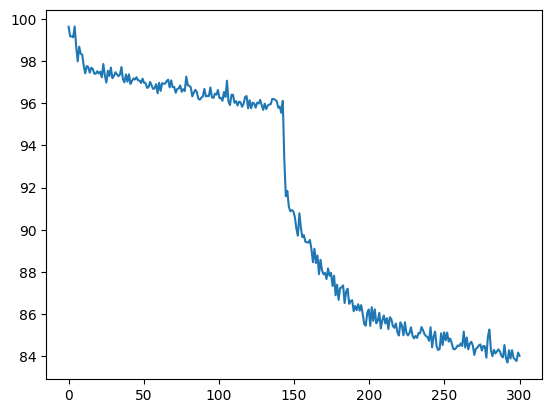

In [60]:
# verifying the convergence of cost
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()